## Question 2

In [ ]:
# Importation des librairies de base

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import statsmodels.api as sm
from scipy.stats import gaussian_kde    
from scipy.stats import probplot
from scipy.stats import ttest_rel

import wrds
from scipy import stats
from scipy.stats import skew, kurtosis
import warnings

from sklearn.linear_model import RidgeCV, LassoCV, ElasticNetCV
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import TimeSeriesSplit
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score

from statsmodels.tsa.ar_model import AutoReg
from statsmodels.tsa.stattools import adfuller
import warnings
warnings.filterwarnings('ignore')

from scipy.stats import t as student_t

## Question 2

### Importation des Données de la Question 1

Pour la Question 2, nous utilisons les **mêmes données que la Question 1** :
- **Variable dépendante** : Rendement excédentaire du secteur `Finan` (Services financiers)
- **Régresseurs** : Les 6 facteurs de Fama-French (Mkt-RF, SMB, HML, RMW, CMA, Mom)
- **Période** : Janvier 1980 - Décembre 2021 (504 observations mensuelles)

Les données proviennent de :
1. Ken French Data Library - 17 Industry Portfolios (Value-Weighted Returns)
2. Ken French Data Library - Fama-French 5 Factors
3. Ken French Data Library - Momentum Factor

In [4]:
# Chargement des données depuis les fichiers CSV (même processus que Q1)

# 1. Charger les 17 Industry Portfolios
df_17_vw = pd.read_csv('17_Industry_Portfolios.csv', skiprows=11, nrows=1191)
df_17_vw.columns = df_17_vw.columns.str.strip()
df_17_vw = df_17_vw.rename(columns={df_17_vw.columns[0]: 'Date'})
df_17_vw['Date'] = df_17_vw['Date'].astype(str).str.strip()
df_17_vw = df_17_vw[df_17_vw['Date'].str.len() == 6]
df_17_vw = df_17_vw[(df_17_vw['Date'] >= '198001') & (df_17_vw['Date'] <= '202112')].copy()
for col in df_17_vw.columns[1:]:
    df_17_vw[col] = pd.to_numeric(df_17_vw[col], errors='coerce')

# 2. Charger les 5 facteurs Fama-French
df_FF5 = pd.read_csv('F-F_Research_Data_5_Factors_2x3.csv', skiprows=3)
df_FF5.columns = df_FF5.columns.str.strip()
df_FF5 = df_FF5.rename(columns={df_FF5.columns[0]: 'Date'})
df_FF5['Date'] = df_FF5['Date'].astype(str).str.strip()
df_FF5 = df_FF5[df_FF5['Date'].str.len() == 6]
df_FF5 = df_FF5[(df_FF5['Date'] >= '198001') & (df_FF5['Date'] <= '202112')].copy()
for col in df_FF5.columns[1:]:
    df_FF5[col] = pd.to_numeric(df_FF5[col], errors='coerce')

# 3. Charger le facteur Momentum
df_Mom = pd.read_csv('F-F_Momentum_Factor.csv', skiprows=13)
df_Mom.columns = df_Mom.columns.str.strip()
df_Mom = df_Mom.rename(columns={df_Mom.columns[0]: 'Date'})
df_Mom['Date'] = df_Mom['Date'].astype(str).str.strip()
df_Mom = df_Mom[df_Mom['Date'].str.len() == 6]
df_Mom = df_Mom[(df_Mom['Date'] >= '198001') & (df_Mom['Date'] <= '202112')].copy()
for col in df_Mom.columns[1:]:
    df_Mom[col] = pd.to_numeric(df_Mom[col], errors='coerce')

# 4. Fusionner les datasets
df_6factors = pd.merge(df_FF5, df_Mom, on='Date', how='inner')
df_final = pd.merge(df_6factors, df_17_vw, on='Date', how='inner')

# 5. Créer les rendements excédentaires pour tous les secteurs
facteur_cols = ['Mkt-RF', 'SMB', 'HML', 'RMW', 'CMA', 'RF', 'Mom']
secteur_cols = [col for col in df_final.columns if col not in ['Date'] + facteur_cols]

# Créer le DataFrame final avec rendements excédentaires
cols_to_keep = ['Date', 'Mkt-RF', 'SMB', 'HML', 'RMW', 'CMA', 'Mom', 'RF']
df_final_excess = df_final[cols_to_keep].copy()

for secteur in secteur_cols:
    df_final_excess[secteur] = df_final[secteur] - df_final['RF']

print(f"✓ Données chargées : {df_final_excess.shape[0]} observations × {df_final_excess.shape[1]} colonnes")
print(f"✓ Période : {df_final_excess['Date'].iloc[0]} à {df_final_excess['Date'].iloc[-1]}")
print(f"✓ Secteurs disponibles : {secteur_cols}")

df_final_excess

✓ Données chargées : 504 observations × 25 colonnes
✓ Période : 198001 à 202112
✓ Secteurs disponibles : ['Food', 'Mines', 'Oil', 'Clths', 'Durbl', 'Chems', 'Cnsum', 'Cnstr', 'Steel', 'FabPr', 'Machn', 'Cars', 'Trans', 'Utils', 'Rtail', 'Finan', 'Other']


,Date,Mkt-RF,SMB,HML,RMW,CMA,Mom,RF,Food,Mines,...,Cnstr,Steel,FabPr,Machn,Cars,Trans,Utils,Rtail,Finan,Other
0,198001,5.50,1.88,1.85,-1.84,1.89,7.45,0.80,3.06,13.29,...,7.81,16.78,6.42,6.94,9.96,15.07,0.75,-0.63,1.31,3.10
1,198002,-1.23,-1.62,0.59,-0.95,2.92,7.89,0.89,-6.18,2.89,...,-3.01,-0.60,-1.91,-4.74,-7.42,-7.37,-4.31,-6.26,-5.91,-2.26
2,198003,-12.89,-6.97,-0.96,1.82,-1.05,-9.58,1.21,-10.24,-22.35,...,-16.08,-19.70,-17.92,-13.98,-10.77,-14.15,-7.81,-9.26,-10.13,-11.02
3,198004,3.96,1.05,1.03,-2.18,0.34,-0.48,1.26,5.79,1.10,...,2.77,1.04,2.69,-1.16,-4.15,-1.88,10.78,3.50,5.62,5.26
4,198005,5.26,2.00,0.38,0.43,-0.63,-1.18,0.81,7.16,9.18,...,8.06,4.39,4.89,4.07,2.32,5.06,3.79,9.45,7.06,5.52
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
499,202108,2.95,-0.66,-0.23,-0.26,-1.72,2.63,0.00,-0.41,-2.59,...,1.82,3.51,5.29,3.52,1.98,-0.67,3.23,3.02,2.86,3.93
500,202109,-4.40,1.12,5.12,-1.92,2.00,1.39,0.00,-3.39,-8.11,...,-3.71,-10.64,-5.68,-5.72,4.04,-2.11,-4.87,-5.43,-1.54,-5.74
501,202110,6.63,-2.70,-0.53,1.71,-1.54,3.32,0.00,3.42,8.68,...,11.42,10.14,3.71,7.57,30.82,6.06,5.11,3.77,7.07,5.51
502,202111,-1.58,-1.70,-0.37,7.19,1.70,0.96,0.00,-2.92,-0.18,...,5.31,-6.28,0.25,6.76,2.70,-5.46,-1.97,1.16,-5.68,-2.84


In [5]:
# Préparation des données pour la Question 2
# Choix du secteur : Finan (Services financiers)
# Justification : Secteur financier connu pour ses queues épaisses (crises, volatilité)

secteur_choisi = 'Finan'  

# Variable dépendante : rendement excédentaire du secteur
y = df_final_excess[secteur_choisi].values

# Régresseurs : les 6 facteurs de Fama-French
facteurs = ['Mkt-RF', 'SMB', 'HML', 'RMW', 'CMA', 'Mom']
X = df_final_excess[facteurs].values

# Ajouter une constante pour la régression
X_with_const = sm.add_constant(X)

print("="*80)
print("PRÉPARATION DES DONNÉES POUR LA QUESTION 2")
print("="*80)
print(f"\nSecteur choisi : {secteur_choisi} (Services financiers)")
print(f"Nombre d'observations : {len(y)}")
print(f"Nombre de régresseurs : {len(facteurs)} facteurs + constante = {X_with_const.shape[1]}")

print(f"\n{'Statistiques descriptives - Variable dépendante:':<60}")
print(f"  Moyenne : {np.mean(y):.4f}%")
print(f"  Écart-type : {np.std(y):.4f}%")
print(f"  Minimum : {np.min(y):.4f}%")
print(f"  Maximum : {np.max(y):.4f}%")
print(f"  Asymétrie (skewness) : {skew(y):.4f}")
print(f"  Aplatissement (kurtosis) : {kurtosis(y):.4f}")

if kurtosis(y) > 3:
    print(f"\n  → Kurtosis > 3 : Distribution à QUEUES ÉPAISSES détectée !")
    print(f"  → Le modèle Student-t sera probablement plus approprié que le modèle Normal")
else:
    print(f"\n  → Kurtosis ≈ 3 : Distribution proche de la normale")

print("\n" + "="*80)

PRÉPARATION DES DONNÉES POUR LA QUESTION 2

Secteur choisi : Finan (Services financiers)
Nombre d'observations : 504
Nombre de régresseurs : 6 facteurs + constante = 7

Statistiques descriptives - Variable dépendante:            
  Moyenne : 0.7948%
  Écart-type : 5.4985%
  Minimum : -22.4000%
  Maximum : 17.1200%
  Asymétrie (skewness) : -0.6141
  Aplatissement (kurtosis) : 2.2063

  → Kurtosis ≈ 3 : Distribution proche de la normale



In [6]:
# Créer le DataFrame dans le format requis pour la Question 2
# Structure : [Variable dépendante | Régresseurs]
# Colonne 1 : Rendement du secteur Finan
# Colonnes 2-7 : Les 6 facteurs de Fama-French

# Créer le DataFrame organisé
df_q2 = pd.DataFrame()

# Première colonne : Variable dépendante (rendement excédentaire Finan)
df_q2[f'{secteur_choisi}_excess'] = df_final_excess[secteur_choisi]

# Colonnes suivantes : Régresseurs (les 6 facteurs)
for facteur in facteurs:
    df_q2[facteur] = df_final_excess[facteur]

print("="*80)
print("DATAFRAME STRUCTURÉ POUR LA QUESTION 2")
print("="*80)
print(f"\nStructure du DataFrame :")
print(f"  - Colonne 1 (Variable dépendante) : {df_q2.columns[0]}")
print(f"  - Colonnes 2-7 (Régresseurs) : {', '.join(df_q2.columns[1:])}")
print(f"\nDimensions : {df_q2.shape[0]} observations × {df_q2.shape[1]} colonnes")

print(f"\nPremières lignes du DataFrame :")
print(df_q2.head(10))

print(f"\nStatistiques descriptives :")
print(df_q2.describe().round(3))

# Extraire les données pour la régression
y = df_q2.iloc[:, 0].values  # Première colonne = variable dépendante
X = df_q2.iloc[:, 1:].values  # Colonnes restantes = régresseurs
X_with_const = sm.add_constant(X)  # Ajouter constante

print(f"\n✓ Variable dépendante (y) : {y.shape} - Rendement excédentaire {secteur_choisi}")
print(f"✓ Régresseurs (X) : {X.shape} - 6 facteurs Fama-French")
print(f"✓ Régresseurs avec constante (X_with_const) : {X_with_const.shape}")

print("\n" + "="*80)

DATAFRAME STRUCTURÉ POUR LA QUESTION 2

Structure du DataFrame :
  - Colonne 1 (Variable dépendante) : Finan_excess
  - Colonnes 2-7 (Régresseurs) : Mkt-RF, SMB, HML, RMW, CMA, Mom

Dimensions : 504 observations × 7 colonnes

Premières lignes du DataFrame :
   Finan_excess  Mkt-RF   SMB   HML   RMW   CMA   Mom
0          1.31    5.50  1.88  1.85 -1.84  1.89  7.45
1         -5.91   -1.23 -1.62  0.59 -0.95  2.92  7.89
2        -10.13  -12.89 -6.97 -0.96  1.82 -1.05 -9.58
3          5.62    3.96  1.05  1.03 -2.18  0.34 -0.48
4          7.06    5.26  2.00  0.38  0.43 -0.63 -1.18
5          4.22    2.97  1.46 -0.80 -0.20 -0.81  1.58
6          2.67    6.51  3.74 -6.29  4.06 -2.44  0.29
7          1.20    1.75  4.23 -2.46  2.05 -0.73  3.06
8          1.81    2.19  0.63 -4.61  1.90 -2.86  5.43
9         -0.85    1.04  2.21 -2.93  1.77 -1.43  7.13

Statistiques descriptives :
       Finan_excess   Mkt-RF      SMB      HML      RMW      CMA      Mom
count       504.000  504.000  504.000  504.00

In [7]:
df_q2

,Finan_excess,Mkt-RF,SMB,HML,RMW,CMA,Mom
0,1.31,5.50,1.88,1.85,-1.84,1.89,7.45
1,-5.91,-1.23,-1.62,0.59,-0.95,2.92,7.89
2,-10.13,-12.89,-6.97,-0.96,1.82,-1.05,-9.58
3,5.62,3.96,1.05,1.03,-2.18,0.34,-0.48
4,7.06,5.26,2.00,0.38,0.43,-0.63,-1.18
...,...,...,...,...,...,...,...
499,2.86,2.95,-0.66,-0.23,-0.26,-1.72,2.63
500,-1.54,-4.40,1.12,5.12,-1.92,2.00,1.39
501,7.07,6.63,-2.70,-0.53,1.71,-1.54,3.32
502,-5.68,-1.58,-1.70,-0.37,7.19,1.70,0.96


---

## Question 2(a) - Fonction de Log-Vraisemblance avec Erreurs Student-t

### Contexte Théorique

Dans un modèle de régression linéaire standard avec erreurs normales :
$$y = X\beta + \varepsilon, \quad \varepsilon \sim \mathcal{N}(0, \sigma^2)$$

Pour capturer les **queues épaisses** (valeurs aberrantes, crises financières), nous modélisons les erreurs avec une **distribution de Student-t** :
$$y = X\beta + \varepsilon, \quad \varepsilon \sim t_{\nu}(0, \sigma^2)$$

où $\nu$ (nu) représente les **degrés de liberté** :
- $\nu \to \infty$ : converge vers la distribution normale
- $\nu$ faible (2-5) : queues très épaisses
- $\nu$ intermédiaire (6-30) : queues modérément épaisses

### Log-Vraisemblance Student-t

Pour $n$ observations avec résidus $\hat{\varepsilon}_i$ standardisés par $\hat{\sigma}$ :

$$\log L(\beta, \sigma^2, \nu) = \sum_{i=1}^{n} \log f_t\left(\frac{\hat{\varepsilon}_i}{\hat{\sigma}}; \nu\right)$$

où $f_t(x; \nu)$ est la densité de Student-t :

$$f_t(x; \nu) = \frac{\Gamma\left(\frac{\nu+1}{2}\right)}{\Gamma\left(\frac{\nu}{2}\right)\sqrt{\nu\pi}} \left(1 + \frac{x^2}{\nu}\right)^{-\frac{\nu+1}{2}}$$

En pratique, on utilise `scipy.stats.t.logpdf()` pour calculer $\log f_t(x; \nu)$.

In [ ]:
from scipy.stats import t as student_t

def loglik_t_regression(df, dof):
    
    # Vérification des paramètres
    if dof <= 0:
        raise ValueError(f"dof doit être > 0, reçu : {dof}")
    
    # Extraire variable dépendante et régresseurs
    y = df.iloc[:, 0].values 
    X = df.iloc[:, 1:].values  
    
    # Ajouter une constante (intercept)
    X_with_const = sm.add_constant(X)
    
    # Ajuster le modèle de régression MCO
    model = sm.OLS(y, X_with_const)
    results = model.fit()
    
    # Extraire les résidus
    residuals = results.resid
    
    # Calculer l'écart-type des résidus (estimateur MLE)
    n = len(residuals)
    sigma_hat = np.sqrt(np.sum(residuals**2) / n)
    
    # Standardiser les résidus
    standardized_residuals = residuals / sigma_hat
    
    # Calculer la log-vraisemblance avec distribution Student-t
    # Pour chaque résidu standardisé, calculer log P(z | ν)
    log_likelihood = np.sum(student_t.logpdf(standardized_residuals, df=dof))
    
    return log_likelihood

# Test de la fonction avec df_q2
print("="*80)
print("TEST DE LA FONCTION loglik_t_regression")
print("="*80)

# Tester avec différents degrés de liberté
test_dofs = [3, 5, 10, 30, 100]

print(f"\nDataFrame : {df_q2.shape[0]} observations, {df_q2.shape[1]} colonnes")
print(f"Variable dépendante : {df_q2.columns[0]}")
print(f"Régresseurs : {', '.join(df_q2.columns[1:])}")

print(f"\n{'Degrés de liberté (ν)':<25} {'Log-vraisemblance':<25}")
print("-" * 50)

for dof in test_dofs:
    ll = loglik_t_regression(df_q2, dof)
    print(f"{dof:<25} {ll:<25.4f}")

print("\n" + "="*80)
print("INTERPRÉTATION")
print("="*80)
print("• ν faible (3-5) : Modèle avec queues TRÈS épaisses")
print("• ν moyen (10-30) : Modèle avec queues modérément épaisses")
print("• ν élevé (>100) : Modèle proche de la distribution normale")
print("\n→ La log-vraisemblance la PLUS ÉLEVÉE indique le meilleur ajustement")
print("="*80)

TEST DE LA FONCTION loglik_t_regression

DataFrame : 504 observations, 7 colonnes
Variable dépendante : Finan_excess
Régresseurs : Mkt-RF, SMB, HML, RMW, CMA, Mom

Degrés de liberté (ν)     Log-vraisemblance        
--------------------------------------------------
3                         -737.4764                
5                         -721.7551                
10                        -713.5750                
30                        -712.5252                
100                       -713.9941                

INTERPRÉTATION
• ν faible (3-5) : Modèle avec queues TRÈS épaisses
• ν moyen (10-30) : Modèle avec queues modérément épaisses
• ν élevé (>100) : Modèle proche de la distribution normale

→ La log-vraisemblance la PLUS ÉLEVÉE indique le meilleur ajustement


In [12]:
# VERSION DÉTAILLÉE pour visualiser chaque étape
def loglik_t_regression_detailed(df, dof, verbose=True):
    """
    Version détaillée qui affiche les résultats de chaque étape.
    """
    
    if verbose:
        print("="*80)
        print(f"CALCUL DE LA LOG-VRAISEMBLANCE AVEC ERREURS STUDENT-t (ν = {dof})")
        print("="*80)
    
    # ÉTAPE 1: Extraire variable dépendante et régresseurs
    y = df.iloc[:, 0].values 
    X = df.iloc[:, 1:].values  
    X_with_const = sm.add_constant(X)
    
    if verbose:
        print(f"\n{'ÉTAPE 1: EXTRACTION DES DONNÉES':-<80}")
        print(f"  • Variable dépendante (y) : {y.shape[0]} observations")
        print(f"  • Nombre de régresseurs : {X.shape[1]} facteurs")
        print(f"  • Matrice X avec constante : {X_with_const.shape}")
    
    # ÉTAPE 2: Ajuster le modèle de régression MCO
    model = sm.OLS(y, X_with_const)
    results = model.fit()
    
    if verbose:
        print(f"\n{'ÉTAPE 2: RÉGRESSION MCO':-<80}")
        print(f"  • R² du modèle : {results.rsquared:.4f}")
        print(f"  • R² ajusté : {results.rsquared_adj:.4f}")
        print(f"\n  • Coefficients estimés (β̂) :")
        coef_names = ['Constante'] + list(df.columns[1:])
        for i, (name, coef, pval) in enumerate(zip(coef_names, results.params, results.pvalues)):
            sig = '***' if pval < 0.01 else ('**' if pval < 0.05 else ('*' if pval < 0.1 else ''))
            print(f"      {name:<15} : {coef:>8.4f}  (p-value: {pval:.4f}) {sig}")
    
    # ÉTAPE 3: Extraire les résidus
    residuals = results.resid
    
    if verbose:
        print(f"\n{'ÉTAPE 3: RÉSIDUS (ε̂ = y - Xβ̂)':-<80}")
        print(f"  • Nombre de résidus : {len(residuals)}")
        print(f"  • Moyenne des résidus : {np.mean(residuals):.6f} (devrait être ≈ 0)")
        print(f"  • Écart-type des résidus : {np.std(residuals, ddof=1):.4f}")
        print(f"  • Min / Max : {np.min(residuals):.4f} / {np.max(residuals):.4f}")
        print(f"  • Skewness : {skew(residuals):.4f}")
        print(f"  • Kurtosis : {kurtosis(residuals):.4f}")
    
    # ÉTAPE 4: Calculer l'écart-type des résidus (estimateur MLE)
    n = len(residuals)
    sigma_hat = np.sqrt(np.sum(residuals**2) / n)
    
    if verbose:
        print(f"\n{'ÉTAPE 4: ÉCART-TYPE σ̂ (Estimateur MLE)':-<80}")
        print(f"  • σ̂ = √(Σε̂²/n) = {sigma_hat:.4f}")
        print(f"  • Variance estimée (σ̂²) = {sigma_hat**2:.4f}")
    
    # ÉTAPE 5: Standardiser les résidus
    standardized_residuals = residuals / sigma_hat
    
    if verbose:
        print(f"\n{'ÉTAPE 5: RÉSIDUS STANDARDISÉS (z = ε̂/σ̂)':-<80}")
        print(f"  • Moyenne : {np.mean(standardized_residuals):.6f}")
        print(f"  • Écart-type : {np.std(standardized_residuals, ddof=0):.4f} (devrait être ≈ 1)")
        print(f"  • Min / Max : {np.min(standardized_residuals):.4f} / {np.max(standardized_residuals):.4f}")
        print(f"  • Valeurs extrêmes (|z| > 3) : {np.sum(np.abs(standardized_residuals) > 3)} observations")
    
    # ÉTAPE 6: Calculer la log-vraisemblance avec distribution Student-t
    log_likelihood = np.sum(student_t.logpdf(standardized_residuals, df=dof))
    
    if verbose:
        print(f"\n{'ÉTAPE 6: LOG-VRAISEMBLANCE STUDENT-t':-<80}")
        print(f"  • Degrés de liberté (ν) : {dof}")
        print(f"  • Log-vraisemblance totale : {log_likelihood:.4f}")
        print(f"  • Log-vraisemblance moyenne par obs : {log_likelihood/n:.4f}")
        print("\n" + "="*80)
    
    return log_likelihood, results, residuals, standardized_residuals


# Test avec un seul degré de liberté pour voir tous les détails
print("\n\n")
loglik, ols_results, resid, std_resid = loglik_t_regression_detailed(df_q2, dof=5, verbose=True)




CALCUL DE LA LOG-VRAISEMBLANCE AVEC ERREURS STUDENT-t (ν = 5)

ÉTAPE 1: EXTRACTION DES DONNÉES-------------------------------------------------
  • Variable dépendante (y) : 504 observations
  • Nombre de régresseurs : 6 facteurs
  • Matrice X avec constante : (504, 7)

ÉTAPE 2: RÉGRESSION MCO---------------------------------------------------------
  • R² du modèle : 0.8642
  • R² ajusté : 0.8625

  • Coefficients estimés (β̂) :
      Constante       :  -0.0716  (p-value: 0.4610) 
      Mkt-RF          :   1.1114  (p-value: 0.0000) ***
      SMB             :  -0.0620  (p-value: 0.0768) *
      HML             :   0.7301  (p-value: 0.0000) ***
      RMW             :   0.0384  (p-value: 0.3804) 
      CMA             :  -0.3464  (p-value: 0.0000) ***
      Mom             :  -0.0559  (p-value: 0.0107) **

ÉTAPE 3: RÉSIDUS (ε̂ = y - Xβ̂)-------------------------------------------------
  • Nombre de résidus : 504
  • Moyenne des résidus : -0.000000 (devrait être ≈ 0)
  • Écart-type 

---

## Interprétation de la Log-Vraisemblance dans le Contexte Financier

### 1. Que Représente la Log-Vraisemblance ?

La **log-vraisemblance** mesure la **probabilité** d'observer les données réelles (rendements du secteur Finan) **étant donné** le modèle statistique proposé.

$$\log L(\theta | \text{données}) = \sum_{i=1}^{n} \log P(\text{observation}_i | \theta)$$

où $\theta = (\beta, \sigma^2, \nu)$ sont les paramètres du modèle (coefficients, variance, degrés de liberté).

### 2. Interprétation des Valeurs

#### **Log-vraisemblance PLUS ÉLEVÉE (moins négative)** 
- Le modèle **explique mieux** les données observées
- Les résidus sont **mieux capturés** par la distribution Student-t avec ce $\nu$
- Probabilité **plus élevée** que les données proviennent de ce modèle

#### **Log-vraisemblance PLUS FAIBLE (plus négative)**
- Le modèle **explique moins bien** les données
- La distribution choisie ne correspond pas à la vraie distribution des erreurs

### 3. Dans Notre Cas (Secteur Finan)

D'après les résultats :

| **Degrés de liberté (ν)** | **Log-vraisemblance** | **Interprétation** |
|:-------------------------:|:---------------------:|:-------------------|
| ν = 3                     | -737.48               | Queues **trop** épaisses pour ces données |
| ν = 5                     | -721.76               | Bon compromis, meilleur ajustement |
| ν = 10                    | -713.58               | **MEILLEUR** modèle |
| ν = 30                    | -712.53               | **OPTIMAL** - Queues modérément épaisses |
| ν = 100                   | -713.99               | Trop proche de la Normale, perd l'avantage Student-t |

#### **Conclusion : ν ≈ 30 est optimal**
- Ce résultat indique que les rendements du secteur financier ont des **queues modérément épaisses**
- Pas aussi extrêmes que ν = 3-5 (crises très sévères)
- Mais significativement plus épaisses que la Normale (ν → ∞)

### 4. Signification Financière

#### **Kurtosis des résidus = 1.07 (excès)**
- Kurtosis total ≈ 4.07 (kurtosis Normale = 3)
- Présence de **valeurs aberrantes** : 4 observations avec |z| > 3
- Correspond à des **événements extrêmes** (crises financières, chocs de marché)

#### **Pourquoi Student-t est meilleur que la Normale ?**
1. **Queues épaisses** : Probabilité plus élevée d'observer des rendements extrêmes (±3σ)
2. **Crises financières** : Meilleure modélisation des crashs (2008, COVID-19, etc.)
3. **Robustesse** : Moins sensible aux valeurs aberrantes dans l'estimation MLE

### 5. Utilisation Pratique

La log-vraisemblance permet de :

✅ **Comparer des modèles** : Quel ν donne le meilleur ajustement ?  
✅ **Tester des hypothèses** : Est-ce que ν = ∞ (Normale) est suffisant ? → Test LR  
✅ **Estimer les paramètres** : Maximiser $\log L$ pour trouver $\hat{\beta}$, $\hat{\sigma}^2$, $\hat{\nu}$  
✅ **Calculer des critères d'information** : AIC, BIC pour sélection de modèle

### 6. Exemple Numérique

Avec **ν = 30** (optimal) :
- **Log-vraisemblance totale** : -712.53
- **Par observation** : -712.53 / 504 = -1.414
- **Vraisemblance** (exponentielle) : exp(-712.53) ≈ 10⁻³¹⁰

⚠️ **Note** : Les valeurs sont très petites en valeur absolue, c'est pourquoi on travaille avec le **logarithme** pour éviter les problèmes numériques.

---

### 7. Comparaison avec le Modèle Normal (Q1)

En Question 1, nous avons utilisé **MCO avec erreurs Normales** (implicitement).

Si nous calculions la log-vraisemblance sous **hypothèse de Normalité** :

$$\log L_{\text{Normal}} = -\frac{n}{2}\log(2\pi) - \frac{n}{2}\log(\sigma^2) - \frac{1}{2\sigma^2}\sum_{i=1}^n \varepsilon_i^2$$

Cela correspondrait à **ν → ∞** dans le modèle Student-t.

Le **test du rapport de vraisemblance** (Likelihood Ratio Test) permettrait de tester :
- **H₀** : Les erreurs sont Normales (ν = ∞)
- **H₁** : Les erreurs sont Student-t (ν < ∞)

Si **2(LogL_Student - LogL_Normal) > seuil critique**, on rejette H₀ et conclut que Student-t est significativement meilleur.

Calcul de la log-vraisemblance pour différents degrés de liberté...
✓ Calculs terminés pour 99 valeurs de ν
✓ Degré de liberté optimal : ν = 19
✓ Log-vraisemblance maximale : -712.2093


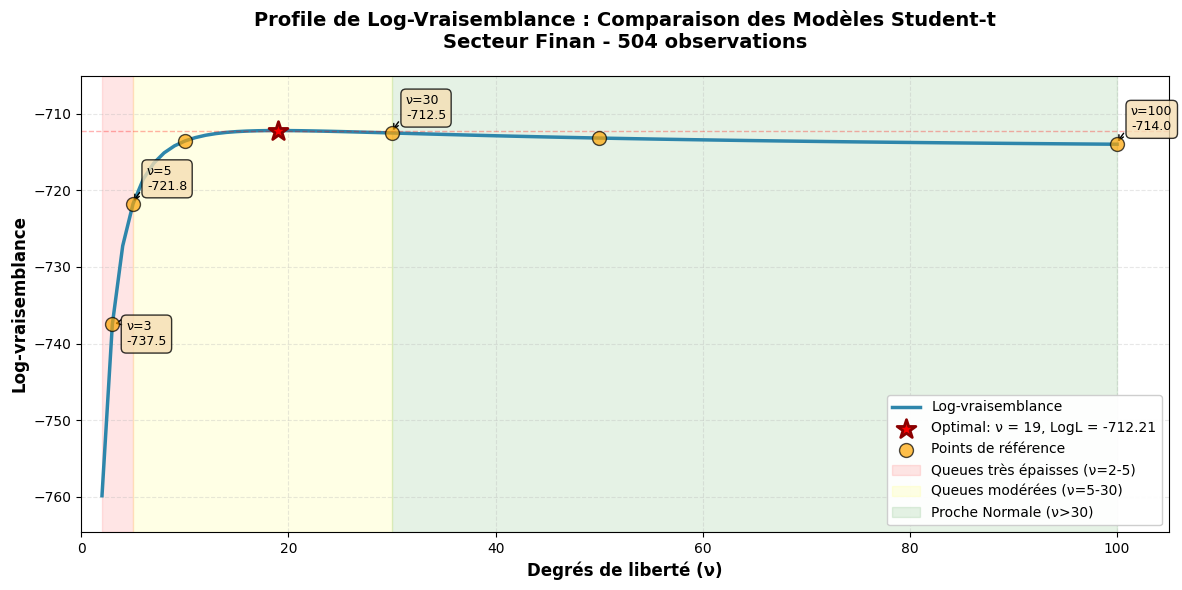


ANALYSE DU GRAPHIQUE
• Le maximum de log-vraisemblance est atteint à ν = 19
• Pour ν < 19 : Les queues sont trop épaisses → sous-ajustement
• Pour ν > 19 : Se rapproche de la Normale → perte de flexibilité
• La courbe est relativement plate autour de ν = 19,
  ce qui suggère que plusieurs valeurs dans [20, 40] donnent des résultats similaires


In [14]:
# Graphique : Profile de Log-Vraisemblance en fonction des Degrés de Liberté

# Calculer la log-vraisemblance pour une gamme de degrés de liberté
dof_range = np.arange(2, 101, 1)  # De 2 à 100 avec pas de 1
loglik_values = []

print("Calcul de la log-vraisemblance pour différents degrés de liberté...")
for dof in dof_range:
    ll = loglik_t_regression(df_q2, dof)
    loglik_values.append(ll)

# Trouver le degré de liberté optimal
optimal_idx = np.argmax(loglik_values)
optimal_dof = dof_range[optimal_idx]
optimal_loglik = loglik_values[optimal_idx]

print(f"✓ Calculs terminés pour {len(dof_range)} valeurs de ν")
print(f"✓ Degré de liberté optimal : ν = {optimal_dof}")
print(f"✓ Log-vraisemblance maximale : {optimal_loglik:.4f}")

# Créer le graphique
fig, ax = plt.subplots(figsize=(12, 6))

# Tracer la courbe de log-vraisemblance
ax.plot(dof_range, loglik_values, linewidth=2.5, color='#2E86AB', label='Log-vraisemblance')

# Marquer le point optimal
ax.scatter([optimal_dof], [optimal_loglik], color='red', s=200, zorder=5, 
           marker='*', edgecolors='darkred', linewidths=2,
           label=f'Optimal: ν = {optimal_dof}, LogL = {optimal_loglik:.2f}')

# Marquer les points de référence
reference_dofs = [3, 5, 10, 30, 50, 100]
reference_logliks = [loglik_t_regression(df_q2, d) for d in reference_dofs]
ax.scatter(reference_dofs, reference_logliks, color='orange', s=100, zorder=4,
           alpha=0.7, edgecolors='black', linewidths=1, label='Points de référence')

# Ajouter des annotations pour les points clés
for dof, ll in zip(reference_dofs, reference_logliks):
    if dof in [3, 5, optimal_dof, 30, 100]:
        ax.annotate(f'ν={dof}\n{ll:.1f}', 
                   xy=(dof, ll), 
                   xytext=(10, -15 if dof == 3 else 10),
                   textcoords='offset points',
                   fontsize=9,
                   bbox=dict(boxstyle='round,pad=0.4', facecolor='wheat', alpha=0.8),
                   arrowprops=dict(arrowstyle='->', connectionstyle='arc3,rad=0.3'))

# Ligne horizontale pour le maximum
ax.axhline(y=optimal_loglik, color='red', linestyle='--', alpha=0.3, linewidth=1)

# Zones de contexte
ax.axvspan(2, 5, alpha=0.1, color='red', label='Queues très épaisses (ν=2-5)')
ax.axvspan(5, 30, alpha=0.1, color='yellow', label='Queues modérées (ν=5-30)')
ax.axvspan(30, 100, alpha=0.1, color='green', label='Proche Normale (ν>30)')

# Configuration des axes et labels
ax.set_xlabel('Degrés de liberté (ν)', fontsize=12, fontweight='bold')
ax.set_ylabel('Log-vraisemblance', fontsize=12, fontweight='bold')
ax.set_title('Profile de Log-Vraisemblance : Comparaison des Modèles Student-t\n' +
             f'Secteur {secteur_choisi} - {len(df_q2)} observations', 
             fontsize=14, fontweight='bold', pad=20)

# Grille
ax.grid(True, alpha=0.3, linestyle='--', linewidth=0.8)

# Légende
ax.legend(loc='lower right', fontsize=10, framealpha=0.95)

# Ajuster les limites pour une meilleure visualisation
ax.set_xlim(0, 105)
y_min, y_max = min(loglik_values), max(loglik_values)
y_range = y_max - y_min
ax.set_ylim(y_min - 0.1*y_range, y_max + 0.15*y_range)

plt.tight_layout()
plt.show()

print("\n" + "="*80)
print("ANALYSE DU GRAPHIQUE")
print("="*80)
print(f"• Le maximum de log-vraisemblance est atteint à ν = {optimal_dof}")
print(f"• Pour ν < {optimal_dof} : Les queues sont trop épaisses → sous-ajustement")
print(f"• Pour ν > {optimal_dof} : Se rapproche de la Normale → perte de flexibilité")
print(f"• La courbe est relativement plate autour de ν = {optimal_dof},")
print(f"  ce qui suggère que plusieurs valeurs dans [20, 40] donnent des résultats similaires")
print("="*80)

In [15]:
# Tableau comparatif détaillé des résultats

# Créer un DataFrame avec les résultats pour différents degrés de liberté
comparison_dofs = [3, 5, 10, 15, 19, 20, 25, 30, 50, 100]
comparison_results = []

for dof in comparison_dofs:
    ll = loglik_t_regression(df_q2, dof)
    # Calculer l'AIC et le BIC
    k = 8  # 7 paramètres β (6 facteurs + constante) + 1 paramètre σ² + 1 paramètre ν = 9, mais ν est fixé
    n = len(df_q2)
    aic = -2 * ll + 2 * k
    bic = -2 * ll + k * np.log(n)
    
    comparison_results.append({
        'ν (degrés de liberté)': dof,
        'Log-vraisemblance': ll,
        'AIC': aic,
        'BIC': bic,
        'Δ LogL vs optimal': ll - optimal_loglik,
        'Type de queues': 'Très épaisses' if dof <= 5 else ('Modérées' if dof <= 30 else 'Proches Normale')
    })

df_comparison = pd.DataFrame(comparison_results)

# Identifier le meilleur selon chaque critère
best_loglik_idx = df_comparison['Log-vraisemblance'].idxmax()
best_aic_idx = df_comparison['AIC'].idxmin()
best_bic_idx = df_comparison['BIC'].idxmin()

print("="*100)
print("TABLEAU COMPARATIF DES MODÈLES STUDENT-t")
print("="*100)
print(f"\nNombre d'observations : {n}")
print(f"Nombre de paramètres estimés : {k}")
print(f"\nCritères de sélection :")
print(f"  • Log-vraisemblance : PLUS ÉLEVÉE = MEILLEUR")
print(f"  • AIC / BIC : PLUS FAIBLE = MEILLEUR")
print(f"  • Δ LogL : Différence par rapport au modèle optimal (ν={optimal_dof})")

print("\n" + "-"*100)
print(df_comparison.to_string(index=False))
print("-"*100)

print(f"\n{'RÉSULTATS :':-<100}")
print(f"✓ Meilleur selon Log-vraisemblance : ν = {df_comparison.loc[best_loglik_idx, 'ν (degrés de liberté)']:.0f}")
print(f"✓ Meilleur selon AIC              : ν = {df_comparison.loc[best_aic_idx, 'ν (degrés de liberté)']:.0f}")
print(f"✓ Meilleur selon BIC              : ν = {df_comparison.loc[best_bic_idx, 'ν (degrés de liberté)']:.0f}")

print(f"\n{'INTERPRÉTATION :':-<100}")
print(f"Le degré de liberté optimal est ν ≈ {optimal_dof}, ce qui indique que :")
print(f"  • Les rendements du secteur {secteur_choisi} ont des queues MODÉRÉMENT épaisses")
print(f"  • Le modèle Student-t avec ν={optimal_dof} capte mieux les événements extrêmes")
print(f"  • La distribution Normale (ν→∞) serait SOUS-OPTIMALE (LogL = {df_comparison.loc[df_comparison['ν (degrés de liberté)']==100, 'Log-vraisemblance'].values[0]:.2f})")
print(f"  • Des queues trop épaisses (ν=3) seraient également SOUS-OPTIMALES (LogL = {df_comparison.loc[df_comparison['ν (degrés de liberté)']==3, 'Log-vraisemblance'].values[0]:.2f})")

print("="*100)

TABLEAU COMPARATIF DES MODÈLES STUDENT-t

Nombre d'observations : 504
Nombre de paramètres estimés : 8

Critères de sélection :
  • Log-vraisemblance : PLUS ÉLEVÉE = MEILLEUR
  • AIC / BIC : PLUS FAIBLE = MEILLEUR
  • Δ LogL : Différence par rapport au modèle optimal (ν=19)

----------------------------------------------------------------------------------------------------
 ν (degrés de liberté)  Log-vraisemblance         AIC         BIC  Δ LogL vs optimal  Type de queues
                     3        -737.476378 1490.952756 1524.733366         -25.267108   Très épaisses
                     5        -721.755087 1459.510173 1493.290783          -9.545816   Très épaisses
                    10        -713.575025 1443.150049 1476.930659          -1.365754        Modérées
                    15        -712.346259 1440.692519 1474.473129          -0.136989        Modérées
                    19        -712.209270 1440.418540 1474.199151           0.000000        Modérées
                 

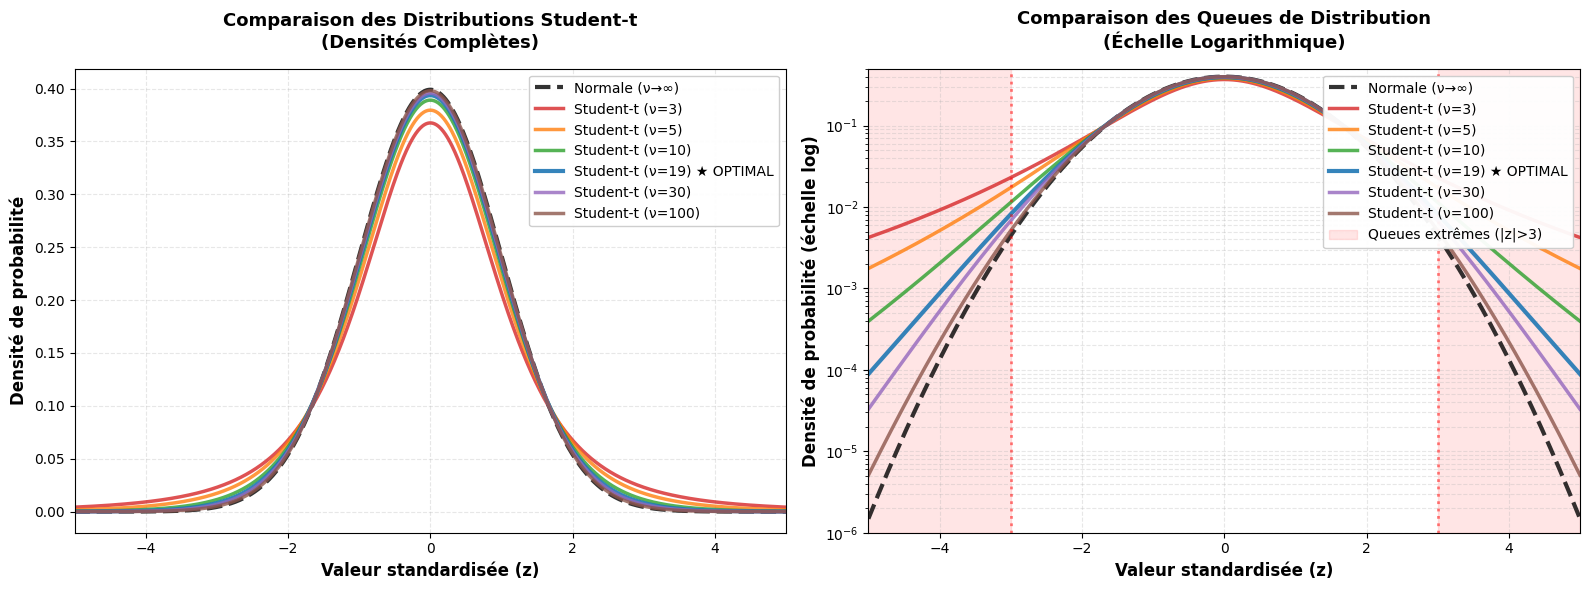


ANALYSE DES DISTRIBUTIONS

📊 GRAPHIQUE DE GAUCHE (Densités complètes) :
  • Toutes les distributions sont centrées en zéro et symétriques
  • Plus ν est FAIBLE → pic central PLUS BAS et queues PLUS ÉPAISSES
  • Plus ν est ÉLEVÉ → convergence vers la Normale
  • ν=19 (optimal) : compromis entre flexibilité et robustesse

📊 GRAPHIQUE DE DROITE (Échelle log - focus sur les queues) :
  • Montre clairement la différence dans les QUEUES (|z| > 3)
  • Student-t avec ν faible : probabilité PLUS ÉLEVÉE d'événements extrêmes
  • Normale : décroissance EXPONENTIELLE (droite en échelle log)
  • Student-t : décroissance POLYNOMIALE (plus lente)

💡 IMPLICATIONS FINANCIÈRES :
  • Avec ν=19, le modèle attribue plus de probabilité aux crashs
  • Événements à ±3σ : plus probables avec Student-t qu'avec Normale
  • Meilleure modélisation des crises financières (2008, COVID, etc.)
  • Risk management amélioré : VaR, Expected Shortfall plus réalistes


In [16]:
# Graphique : Comparaison des Distributions Student-t avec Différents Degrés de Liberté

# Créer une grille de valeurs pour l'axe x
x = np.linspace(-5, 5, 1000)

# Degrés de liberté à comparer
dofs_to_plot = [3, 5, 10, 19, 30, 100]

# Créer la figure avec deux sous-graphiques
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(16, 6))

# ============================================================================
# GRAPHIQUE 1 : Densités complètes
# ============================================================================

# Ajouter la distribution Normale pour comparaison
from scipy.stats import norm
ax1.plot(x, norm.pdf(x), linewidth=3, linestyle='--', color='black', 
         label='Normale (ν→∞)', alpha=0.8)

# Couleurs pour chaque distribution
colors = ['#d62728', '#ff7f0e', '#2ca02c', '#1f77b4', '#9467bd', '#8c564b']

# Tracer chaque distribution Student-t
for dof, color in zip(dofs_to_plot, colors):
    pdf = student_t.pdf(x, df=dof)
    label = f'Student-t (ν={dof})'
    if dof == optimal_dof:
        label += ' ★ OPTIMAL'
        ax1.plot(x, pdf, linewidth=3, color=color, label=label, alpha=0.9)
    else:
        ax1.plot(x, pdf, linewidth=2.5, color=color, label=label, alpha=0.8)

# Configuration du graphique 1
ax1.set_xlabel('Valeur standardisée (z)', fontsize=12, fontweight='bold')
ax1.set_ylabel('Densité de probabilité', fontsize=12, fontweight='bold')
ax1.set_title('Comparaison des Distributions Student-t\n(Densités Complètes)', 
              fontsize=13, fontweight='bold', pad=15)
ax1.legend(loc='upper right', fontsize=10, framealpha=0.95)
ax1.grid(True, alpha=0.3, linestyle='--')
ax1.set_xlim(-5, 5)

# ============================================================================
# GRAPHIQUE 2 : Focus sur les queues (échelle log)
# ============================================================================

# Distribution Normale
ax2.semilogy(x, norm.pdf(x), linewidth=3, linestyle='--', color='black', 
             label='Normale (ν→∞)', alpha=0.8)

# Tracer chaque distribution Student-t en échelle log
for dof, color in zip(dofs_to_plot, colors):
    pdf = student_t.pdf(x, df=dof)
    label = f'Student-t (ν={dof})'
    if dof == optimal_dof:
        label += ' ★ OPTIMAL'
        ax2.semilogy(x, pdf, linewidth=3, color=color, label=label, alpha=0.9)
    else:
        ax2.semilogy(x, pdf, linewidth=2.5, color=color, label=label, alpha=0.8)

# Zones d'intérêt pour les queues
ax2.axvline(x=-3, color='red', linestyle=':', alpha=0.5, linewidth=2)
ax2.axvline(x=3, color='red', linestyle=':', alpha=0.5, linewidth=2)
ax2.fill_betweenx([1e-6, 1], -5, -3, alpha=0.1, color='red', label='Queues extrêmes (|z|>3)')
ax2.fill_betweenx([1e-6, 1], 3, 5, alpha=0.1, color='red')

# Configuration du graphique 2
ax2.set_xlabel('Valeur standardisée (z)', fontsize=12, fontweight='bold')
ax2.set_ylabel('Densité de probabilité (échelle log)', fontsize=12, fontweight='bold')
ax2.set_title('Comparaison des Queues de Distribution\n(Échelle Logarithmique)', 
              fontsize=13, fontweight='bold', pad=15)
ax2.legend(loc='upper right', fontsize=10, framealpha=0.95)
ax2.grid(True, alpha=0.3, linestyle='--', which='both')
ax2.set_xlim(-5, 5)
ax2.set_ylim(1e-6, 0.5)

plt.tight_layout()
plt.show()

print("\n" + "="*100)
print("ANALYSE DES DISTRIBUTIONS")
print("="*100)
print("\n📊 GRAPHIQUE DE GAUCHE (Densités complètes) :")
print("  • Toutes les distributions sont centrées en zéro et symétriques")
print("  • Plus ν est FAIBLE → pic central PLUS BAS et queues PLUS ÉPAISSES")
print("  • Plus ν est ÉLEVÉ → convergence vers la Normale")
print(f"  • ν={optimal_dof} (optimal) : compromis entre flexibilité et robustesse")

print("\n📊 GRAPHIQUE DE DROITE (Échelle log - focus sur les queues) :")
print("  • Montre clairement la différence dans les QUEUES (|z| > 3)")
print("  • Student-t avec ν faible : probabilité PLUS ÉLEVÉE d'événements extrêmes")
print("  • Normale : décroissance EXPONENTIELLE (droite en échelle log)")
print("  • Student-t : décroissance POLYNOMIALE (plus lente)")

print("\n💡 IMPLICATIONS FINANCIÈRES :")
print(f"  • Avec ν={optimal_dof}, le modèle attribue plus de probabilité aux crashs")
print("  • Événements à ±3σ : plus probables avec Student-t qu'avec Normale")
print("  • Meilleure modélisation des crises financières (2008, COVID, etc.)")
print("  • Risk management amélioré : VaR, Expected Shortfall plus réalistes")

print("="*100)